In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle

In [35]:
arrest = pd.read_csv('/content/NYPD_Arrest_Data__Year_to_Date_.csv')
arrest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260503 entries, 0 to 260502
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ARREST_KEY                260503 non-null  int64  
 1   ARREST_DATE               260503 non-null  object 
 2   PD_CD                     260495 non-null  float64
 3   PD_DESC                   260503 non-null  object 
 4   KY_CD                     260471 non-null  float64
 5   OFNS_DESC                 260503 non-null  object 
 6   LAW_CODE                  260503 non-null  object 
 7   LAW_CAT_CD                259113 non-null  object 
 8   ARREST_BORO               260503 non-null  object 
 9   ARREST_PRECINCT           260503 non-null  int64  
 10  JURISDICTION_CODE         260503 non-null  int64  
 11  AGE_GROUP                 260503 non-null  object 
 12  PERP_SEX                  260503 non-null  object 
 13  PERP_RACE                 260503 non-null  o

In [36]:
arrest.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,281369711,01/30/2024,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306501,F,M,25,0,25-44,M,BLACK,1000558,231080,40.800930,-73.941098,POINT (-73.9410982410066 40.8009303727402)
1,284561406,03/30/2024,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,B,44,0,25-44,M,BLACK,1004297,242846,40.833209,-73.927554,POINT (-73.927554 40.833209)
2,284896016,04/06/2024,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,M,19,0,25-44,M,BLACK,997304,222853,40.778348,-73.952863,POINT (-73.952863 40.778348)
3,285569016,04/18/2024,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,K,69,0,25-44,M,BLACK,1010576,175628,40.648698,-73.905128,POINT (-73.905128 40.648698)
4,287308954,05/22/2024,464.0,JOSTLING,230.0,JOSTLING,PL 1652501,M,M,18,0,18-24,M,WHITE,991530,217373,40.763313,-73.973717,POINT (-73.973717 40.763313)


In [37]:
print(arrest.describe())

         ARREST_KEY          PD_CD          KY_CD  ARREST_PRECINCT  \
count  2.605030e+05  260495.000000  260471.000000    260503.000000   
mean   2.893983e+08     431.642008     252.544955        63.410936   
std    5.439968e+06     271.557874     144.942419        34.955962   
min    2.797635e+08       2.000000     101.000000         1.000000   
25%    2.847299e+08     117.000000     114.000000        40.000000   
50%    2.894597e+08     397.000000     341.000000        63.000000   
75%    2.941042e+08     705.000000     344.000000       101.000000   
max    2.987485e+08     997.000000     995.000000       483.000000   

       JURISDICTION_CODE    X_COORD_CD     Y_COORD_CD       Latitude  \
count      260503.000000  2.605030e+05  260503.000000  260499.000000   
mean            0.904542  1.005552e+06  207816.822739      40.735495   
std             6.882318  2.203680e+04   29500.726774       0.265042   
min             0.000000  0.000000e+00       0.000000       0.000000   
25%      

In [38]:
print(arrest.isnull().sum())
arrest.dropna(inplace=True)
print(arrest.isnull().sum())

ARREST_KEY                     0
ARREST_DATE                    0
PD_CD                          8
PD_DESC                        0
KY_CD                         32
OFNS_DESC                      0
LAW_CODE                       0
LAW_CAT_CD                  1390
ARREST_BORO                    0
ARREST_PRECINCT                0
JURISDICTION_CODE              0
AGE_GROUP                      0
PERP_SEX                       0
PERP_RACE                      0
X_COORD_CD                     0
Y_COORD_CD                     0
Latitude                       4
Longitude                      4
New Georeferenced Column       4
dtype: int64
ARREST_KEY                  0
ARREST_DATE                 0
PD_CD                       0
PD_DESC                     0
KY_CD                       0
OFNS_DESC                   0
LAW_CODE                    0
LAW_CAT_CD                  0
ARREST_BORO                 0
ARREST_PRECINCT             0
JURISDICTION_CODE           0
AGE_GROUP                   0


In [39]:
borough_mapping = {'K': 'Brooklyn', 'M': 'Manhattan', 'Q': 'Queens', 'S': 'Staten Island', 'B': 'Bronx'}
arrest['ARREST_BORO'] = arrest['ARREST_BORO'].map(borough_mapping)


In [40]:
numerical_features = arrest.select_dtypes(include=np.number).columns
numerical_features = numerical_features[numerical_features != 'JURISDICTION_CODE']
total_rows = len(arrest)
for column in numerical_features:
    Q1 = arrest[column].quantile(0.25)
    Q3 = arrest[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (arrest[column] < lower_bound) | (arrest[column] > upper_bound)

    arrest = arrest[~outliers]


In [41]:
for col in arrest.columns:
    if arrest[col].dtype == 'object':
        arrest[col] = arrest[col].str.lower()

In [42]:
arrest['ARREST_DATE'] = pd.to_datetime(arrest['ARREST_DATE'])

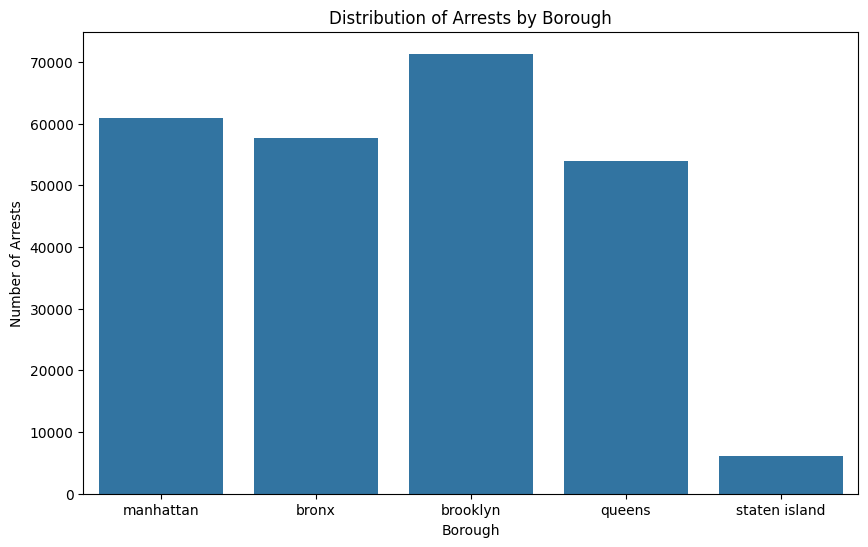

In [43]:
plt.figure(figsize=(10, 6))
sns.countplot(x='ARREST_BORO', data=arrest)
plt.title('Distribution of Arrests by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Arrests')
plt.show()

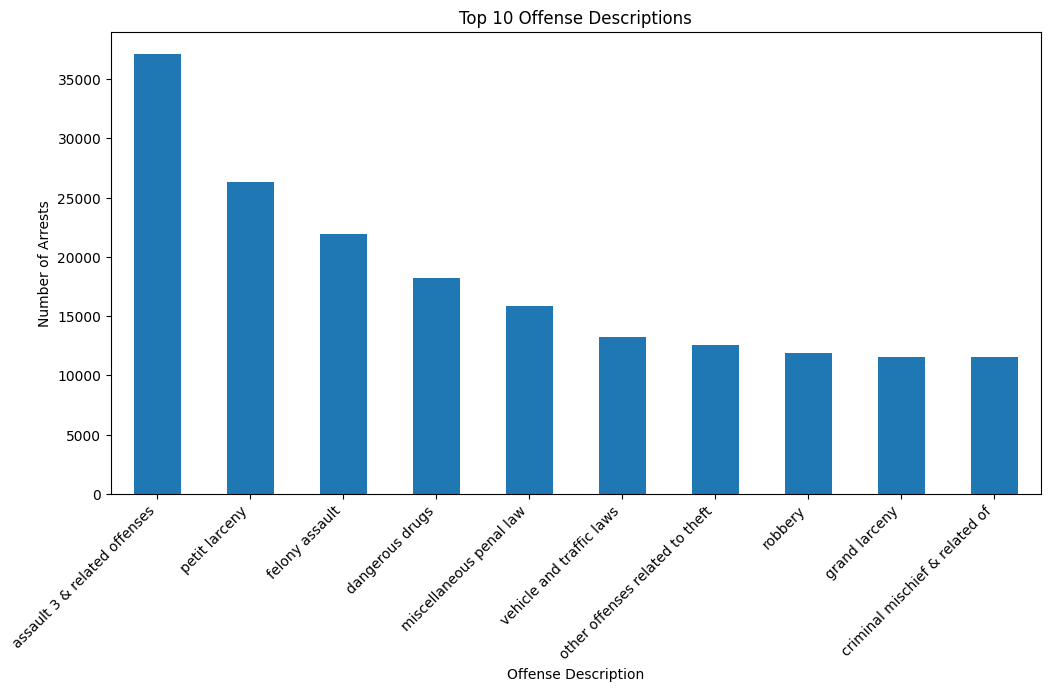

In [44]:
top_10_offenses = arrest['OFNS_DESC'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_10_offenses.plot(kind='bar')
plt.title('Top 10 Offense Descriptions')
plt.xlabel('Offense Description')
plt.ylabel('Number of Arrests')
plt.xticks(rotation=45, ha='right')
plt.show()

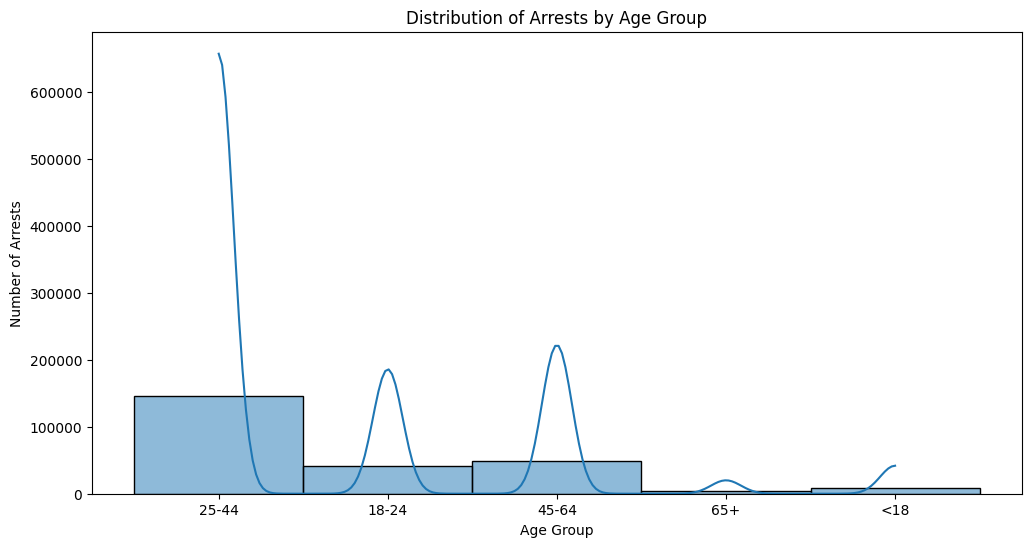

In [45]:
plt.figure(figsize=(12, 6))
sns.histplot(arrest['AGE_GROUP'], bins=20, kde=True)
plt.title('Distribution of Arrests by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Arrests')
plt.show()


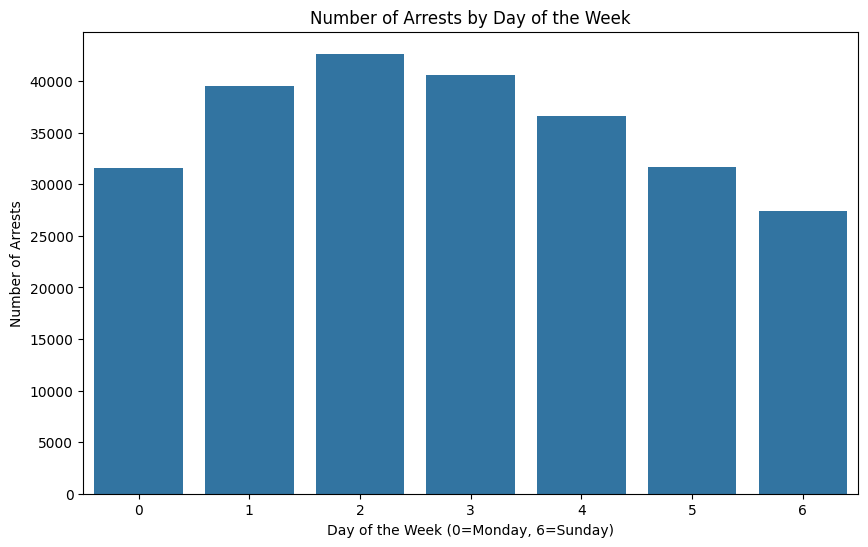

In [46]:
arrest['DayOfWeek'] = arrest['ARREST_DATE'].dt.dayofweek
plt.figure(figsize=(10, 6))
sns.countplot(x='DayOfWeek', data=arrest)
plt.title('Number of Arrests by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Arrests')
plt.show()

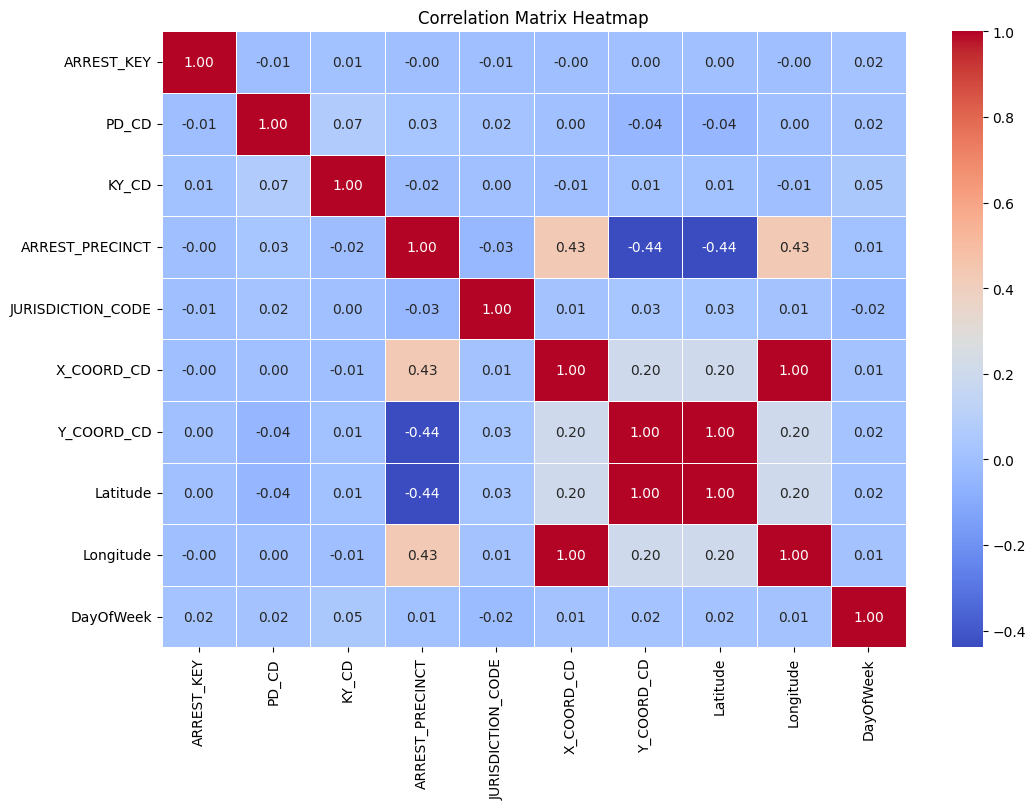

In [47]:
numerical_columns = arrest.select_dtypes(include=np.number).columns
correlation_matrix = arrest[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [48]:
correlation_threshold = 0.13
low_correlation_columns = correlation_matrix.columns[correlation_matrix.abs().mean() < correlation_threshold]
arrest = arrest.drop(columns=low_correlation_columns)
print("Dropped columns with low correlation:", low_correlation_columns.tolist())

Dropped columns with low correlation: ['ARREST_KEY', 'PD_CD', 'KY_CD', 'JURISDICTION_CODE', 'DayOfWeek']


In [49]:
for col in arrest.columns:
    if arrest[col].dtype == 'object':
        print(f'{col}: {arrest[col].nunique()}')
arrest = arrest.drop(columns=['New Georeferenced Column', 'LAW_CODE', 'PD_DESC'])
categorical_cols = arrest.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'PERP_SEX']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(arrest[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
arrest = pd.concat([arrest, encoded_df], axis=1)
arrest = arrest.drop(columns=categorical_cols)
print(arrest.head())


PD_DESC: 236
OFNS_DESC: 55
LAW_CODE: 1077
LAW_CAT_CD: 5
ARREST_BORO: 5
AGE_GROUP: 5
PERP_SEX: 2
PERP_RACE: 7
New Georeferenced Column: 41820
  ARREST_DATE  ARREST_PRECINCT PERP_SEX  X_COORD_CD  Y_COORD_CD   Latitude  \
0  2024-01-30             25.0        m   1000558.0    231080.0  40.800930   
1  2024-03-30             44.0        m   1004297.0    242846.0  40.833209   
2  2024-04-06             19.0        m    997304.0    222853.0  40.778348   
3  2024-04-18             69.0        m   1010576.0    175628.0  40.648698   
4  2024-05-22             18.0        m    991530.0    217373.0  40.763313   

   Longitude  OFNS_DESC_administrative code  OFNS_DESC_administrative codes  \
0 -73.941098                            0.0                             0.0   
1 -73.927554                            0.0                             0.0   
2 -73.952863                            0.0                             0.0   
3 -73.905128                            0.0                             0.

In [17]:
numerical_cols = arrest.select_dtypes(include=np.number).columns
min_max_values = {}
for col in numerical_cols:
    min_val = arrest[col].min()
    max_val = arrest[col].max()
    min_max_values[col] = (min_val, max_val)
for col, (min_val, max_val) in min_max_values.items():
    if max_val - min_val != 0:
      arrest[col] = (arrest[col] - min_val) / (max_val - min_val)
print(arrest.head())

  ARREST_DATE  ARREST_PRECINCT PERP_SEX  X_COORD_CD  Y_COORD_CD  Latitude  \
0  2024-01-30         0.198347        m    0.459990    0.687161  0.687280   
1  2024-03-30         0.355372        m    0.495202    0.778720  0.778791   
2  2024-04-06         0.148760        m    0.429346    0.623141  0.623259   
3  2024-04-18         0.561983        m    0.554333    0.255651  0.255697   
4  2024-05-22         0.140496        m    0.374971    0.580498  0.580634   

   Longitude  OFNS_DESC_administrative code  OFNS_DESC_administrative codes  \
0   0.460071                            0.0                             0.0   
1   0.495456                            0.0                             0.0   
2   0.429335                            0.0                             0.0   
3   0.554045                            0.0                             0.0   
4   0.374854                            0.0                             0.0   

   OFNS_DESC_alcoholic beverage control law  ...  AGE_GROUP_45

In [18]:
arrest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132049 entries, 0 to 127310
Data columns (total 83 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   ARREST_DATE                                 127315 non-null  datetime64[ns]
 1   ARREST_PRECINCT                             127315 non-null  float64       
 2   PERP_SEX                                    127315 non-null  object        
 3   X_COORD_CD                                  127315 non-null  float64       
 4   Y_COORD_CD                                  127315 non-null  float64       
 5   Latitude                                    127315 non-null  float64       
 6   Longitude                                   127315 non-null  float64       
 7   OFNS_DESC_administrative code               127315 non-null  float64       
 8   OFNS_DESC_administrative codes              127315 non-null  float64       
 9 

In [19]:
arrest['ARREST_DATE'] = pd.to_datetime(arrest['ARREST_DATE']).astype('int64') // 10**9

In [20]:
arrest = arrest[arrest['PERP_SEX'].isin(['m', 'f'])]
encoder = LabelEncoder()
y = encoder.fit_transform(arrest['PERP_SEX'])

In [21]:
X = arrest.drop('PERP_SEX', axis=1)
X.dropna()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (89120, 82) (89120,)
Testing set shape: (19097, 82) (19097,)
Validation set shape: (19098, 82) (19098,)


In [22]:
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_val = pd.DataFrame(X_val)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_val_imputed = imputer.transform(X_val)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [23]:
results = {
    'Model': [],
    'Test Accuracy': [],
    'Validation Accuracy': [],
    'Test Loss' : [],
    'Validation Loss' : [],
    'Time Taken': [],
    'Predictions': [],
    'True Labels': []
}

In [24]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)
y_pred_test = rf_classifier.predict(X_test_scaled)
y_pred_val = rf_classifier.predict(X_val_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_val = accuracy_score(y_val, y_pred_val)
y_pred_prob_test = rf_classifier.predict_proba(X_test_scaled)
y_pred_prob_val = rf_classifier.predict_proba(X_val_scaled)
log_loss_test = log_loss(y_test, y_pred_prob_test)
log_loss_val = log_loss(y_val, y_pred_prob_val)
print(f"Test Accuracy: {accuracy_test}")
print(classification_report(y_test, y_pred_test))
print(f"Test Loss: {log_loss_test}")
print(f"Validation Accuracy: {accuracy_val}")
print(classification_report(y_val, y_pred_val))
print(f"Validation Loss: {log_loss_val}")
rf_time = time.time() - start_time
results['Model'].append('Random Forest')
results['Test Accuracy'].append(accuracy_test)
results['Validation Accuracy'].append(accuracy_val)
results['Test Loss'].append(log_loss_test)
results['Validation Loss'].append(log_loss_val)
results['Time Taken'].append(rf_time)
results['Predictions'].append(y_pred_val)
results['True Labels'].append(y_test)


Test Accuracy: 0.8118029009792114
              precision    recall  f1-score   support

           0       0.26      0.02      0.04      3457
           1       0.82      0.99      0.90     15640

    accuracy                           0.81     19097
   macro avg       0.54      0.50      0.47     19097
weighted avg       0.72      0.81      0.74     19097

Test Loss: 0.5028680276070993
Validation Accuracy: 0.8109749712011729
              precision    recall  f1-score   support

           0       0.29      0.02      0.04      3484
           1       0.82      0.99      0.90     15614

    accuracy                           0.81     19098
   macro avg       0.55      0.51      0.47     19098
weighted avg       0.72      0.81      0.74     19098

Validation Loss: 0.5024790404795249


In [25]:
start_time = time.time()
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)
y_pred_knn_test = knn_classifier.predict(X_test_scaled)
y_pred_knn_val = knn_classifier.predict(X_val_scaled)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
accuracy_knn_val = accuracy_score(y_val, y_pred_knn_val)
y_pred_knn_prob_test = knn_classifier.predict_proba(X_test_scaled)
y_pred_knn_prob_val = knn_classifier.predict_proba(X_val_scaled)
log_loss_knn_test = log_loss(y_test, y_pred_knn_prob_test)
log_loss_knn_val = log_loss(y_val, y_pred_knn_prob_val)
print(f"KNN Test Accuracy: {accuracy_knn_test}")
print(classification_report(y_test, y_pred_knn_test))
print(f"Test Loss: {log_loss_test}")
print(f"KNN Validation Accuracy: {accuracy_knn_val}")
print(classification_report(y_val, y_pred_knn_val))
print(f"Validation Loss: {log_loss_val}")
knn_time = time.time() - start_time
results['Model'].append('KNN')
results['Test Accuracy'].append(accuracy_knn_test)
results['Validation Accuracy'].append(accuracy_knn_test)
results['Test Loss'].append(log_loss_knn_test)
results['Validation Loss'].append(log_loss_knn_val)
results['Time Taken'].append(knn_time)
results['Predictions'].append(y_pred_knn_val)
results['True Labels'].append(y_test)


KNN Test Accuracy: 0.7897575535424413
              precision    recall  f1-score   support

           0       0.16      0.04      0.06      3457
           1       0.82      0.96      0.88     15640

    accuracy                           0.79     19097
   macro avg       0.49      0.50      0.47     19097
weighted avg       0.70      0.79      0.73     19097

Test Loss: 0.5028680276070993
KNN Validation Accuracy: 0.7880929940307886
              precision    recall  f1-score   support

           0       0.18      0.04      0.07      3484
           1       0.82      0.95      0.88     15614

    accuracy                           0.79     19098
   macro avg       0.50      0.50      0.48     19098
weighted avg       0.70      0.79      0.73     19098

Validation Loss: 0.5024790404795249


In [26]:
start_time = time.time()
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_scaled, y_train)
y_pred_gb_test = gb_classifier.predict(X_test_scaled)
y_pred_gb_val = gb_classifier.predict(X_val_scaled)
accuracy_gb_test = accuracy_score(y_test, y_pred_gb_test)
accuracy_gb_val = accuracy_score(y_val, y_pred_gb_val)
y_pred_gb_prob_test = gb_classifier.predict_proba(X_test_scaled)
y_pred_gb_prob_val = gb_classifier.predict_proba(X_val_scaled)
log_loss_test = log_loss(y_test, y_pred_gb_prob_test)
log_loss_val = log_loss(y_val, y_pred_gb_prob_val)
print(f"Gradient Boosting Test Accuracy: {accuracy_gb_test}")
print(classification_report(y_test, y_pred_gb_test))
print(f"Test Loss: {log_loss_test}")
print(f"Gradient Boosting Validation Accuracy: {accuracy_gb_val}")
print(classification_report(y_val, y_pred_gb_val))
print(f"Validation Loss: {log_loss_val}")
gb_time = time.time() - start_time
results['Model'].append('Gradient Boosting')
results['Test Accuracy'].append(accuracy_gb_test)
results['Validation Accuracy'].append(accuracy_gb_val)
results['Test Loss'].append(log_loss_test)
results['Validation Loss'].append(log_loss_val)
results['Time Taken'].append(gb_time)
results['Predictions'].append(y_pred_gb_val)
results['True Labels'].append(y_test)

Gradient Boosting Test Accuracy: 0.8193433523590092
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3457
           1       0.82      1.00      0.90     15640

    accuracy                           0.82     19097
   macro avg       0.91      0.50      0.45     19097
weighted avg       0.85      0.82      0.74     19097

Test Loss: 0.46843891998461934
Gradient Boosting Validation Accuracy: 0.8173630746675045
              precision    recall  f1-score   support

           0       0.17      0.00      0.00      3484
           1       0.82      1.00      0.90     15614

    accuracy                           0.82     19098
   macro avg       0.49      0.50      0.45     19098
weighted avg       0.70      0.82      0.74     19098

Validation Loss: 0.4714848800858225


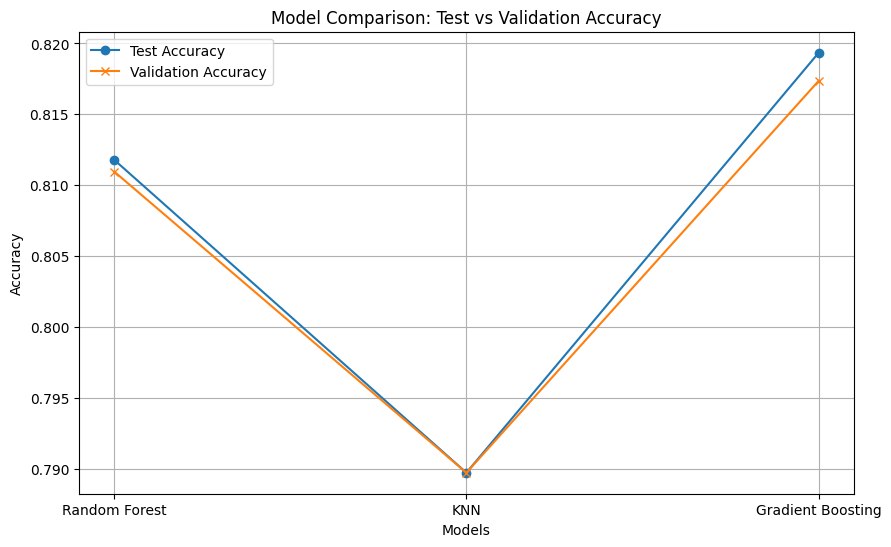

In [27]:
models = results['Model']
test_accuracies = results['Test Accuracy']
val_accuracies = results['Validation Accuracy']
plt.figure(figsize=(10, 6))
plt.plot(models, test_accuracies, marker='o', label='Test Accuracy')
plt.plot(models, val_accuracies, marker='x', label='Validation Accuracy')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison: Test vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


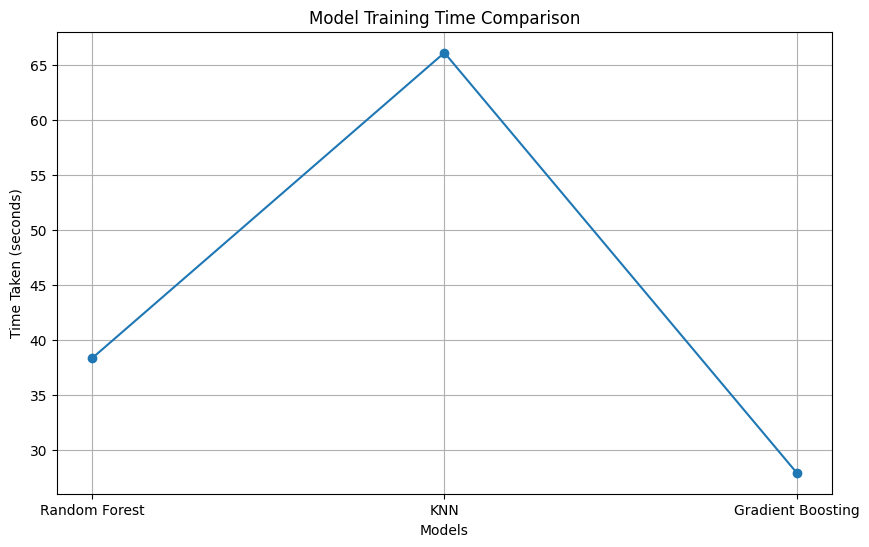

In [28]:
models = results['Model']
times = results['Time Taken']
plt.figure(figsize=(10, 6))
plt.plot(models, times, marker='o', linestyle='-')
plt.xlabel("Models")
plt.ylabel("Time Taken (seconds)")
plt.title("Model Training Time Comparison")
plt.grid(True)
plt.show()


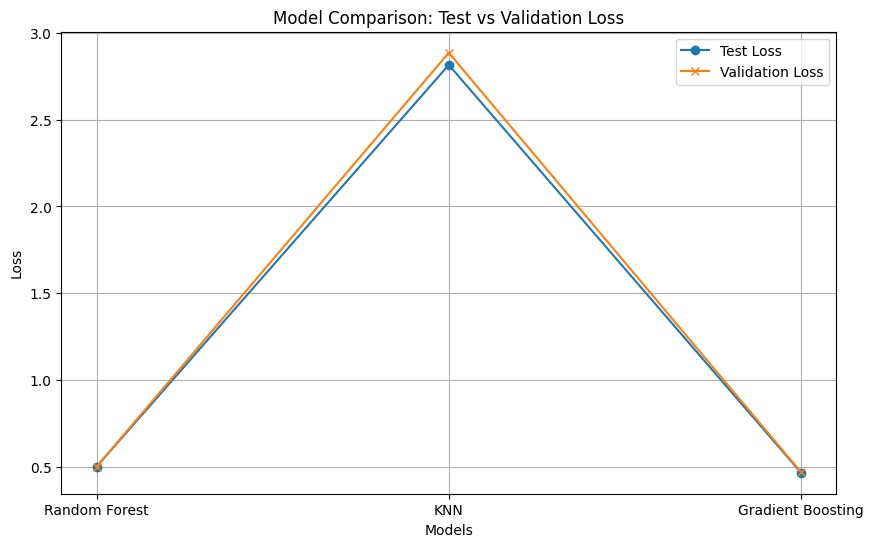

In [29]:
models = results['Model']
test_losses = results['Test Loss']
val_losses = results['Validation Loss']
plt.figure(figsize=(10, 6))
plt.plot(models, test_losses, marker='o', label='Test Loss')
plt.plot(models, val_losses, marker='x', label='Validation Loss')
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Model Comparison: Test vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(np.unique(y_train))
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
batch_size = 100
total_step = len(X_train)
start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
training_time = time.time() - start_time
with open('a0_part2_mythrish.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)

print("Weights saved to a0_part2_mythrish.pkl successfully!")
with torch.no_grad():
    outputs_test = model(X_test)
    _, predicted_test = torch.max(outputs_test.data, 1)
    test_accuracy = accuracy_score(y_test.numpy(), predicted_test.numpy())
    outputs_val = model(X_val)
    _, predicted_val = torch.max(outputs_val.data, 1)
    val_accuracy = accuracy_score(y_val.numpy(), predicted_val.numpy())
    test_loss = criterion(outputs_test, y_test)
    val_loss = criterion(outputs_val, y_val)
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Log Loss: {test_loss.item()}')
    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation Log Loss: {val_loss.item()}')
results['Model'].append('Neural Network')
results['Test Accuracy'].append(test_accuracy)
results['Validation Accuracy'].append(val_accuracy)
results['Test Loss'].append(test_loss.item())
results['Validation Loss'].append(val_loss.item())
results['Time Taken'].append(training_time)
results['Predictions'].append(predicted_val.numpy())
results['True Labels'].append(y_val.numpy())

Weights saved to a0_part2_mythrish.pkl successfully!
Test Accuracy: 0.7776090485416558
Test Log Loss: 0.8705705404281616
Validation Accuracy: 0.773641218975809
Validation Log Loss: 0.923803448677063


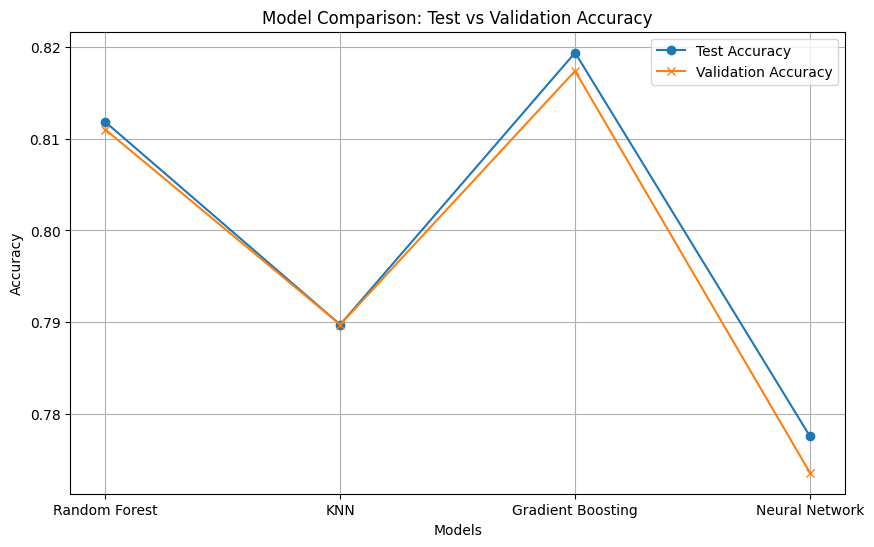

In [31]:
models = results['Model']
test_accuracies = results['Test Accuracy']
val_accuracies = results['Validation Accuracy']
plt.figure(figsize=(10, 6))
plt.plot(models, test_accuracies, marker='o', label='Test Accuracy')
plt.plot(models, val_accuracies, marker='x', label='Validation Accuracy')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison: Test vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


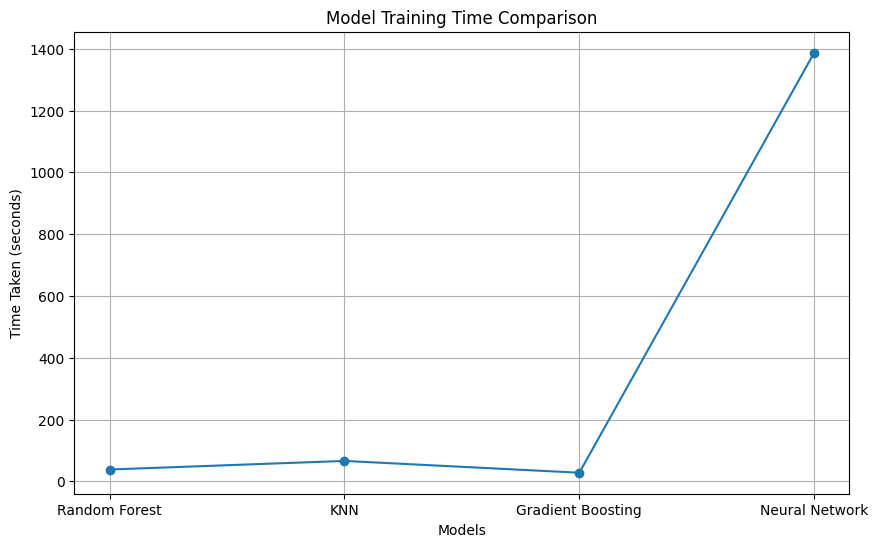

In [32]:
models = results['Model']
times = results['Time Taken']
plt.figure(figsize=(10, 6))
plt.plot(models, times, marker='o', linestyle='-')
plt.xlabel("Models")
plt.ylabel("Time Taken (seconds)")
plt.title("Model Training Time Comparison")
plt.grid(True)
plt.show()


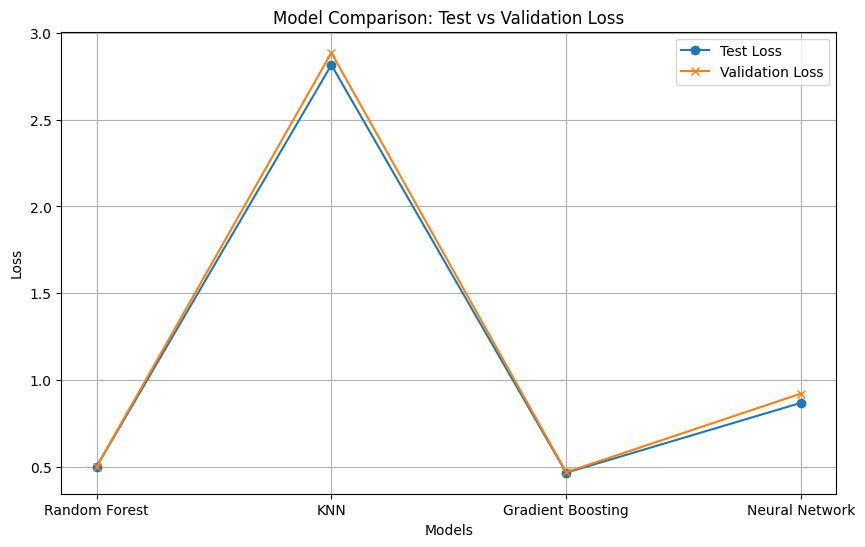

In [33]:
models = results['Model']
test_losses = results['Test Loss']
val_losses = results['Validation Loss']
plt.figure(figsize=(10, 6))
plt.plot(models, test_losses, marker='o', label='Test Loss')
plt.plot(models, val_losses, marker='x', label='Validation Loss')
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Model Comparison: Test vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()